In [1]:
%autosave 0

Autosave disabled


ideas:
1. data processing - one hot encoding, normalization
2. quick EDA
3. set up cv5
4. get a baseline performance by using the data as it is with a few models (lr, svm, random forest, lda)
5. feature engineering and re-train

# Data import and cleaning

In [63]:
train_path = "data/train.csv"
test_path = "data/test.csv"

In [64]:
import numpy as np
import pandas as pd

In [65]:
import matplotlib.pyplot as plt

In [66]:
train_df = pd.read_csv(train_path)

In [67]:
test_df = pd.read_csv(test_path)

In [68]:
train_df.head()

,age,cost_of_ad,device_type,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome
0,56,0.005737,iPhone,M,0,62717,2,1,4,0
1,50,0.004733,desktop,F,0,64328,2,3,2,0
2,54,0.004129,laptop,M,0,83439,1,3,7,0
3,16,0.005117,Android,F,0,30110,2,3,0,0
4,37,0.003635,desktop,M,0,76565,2,1,5,0


In [69]:
train_df.describe()

,age,cost_of_ad,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.0000
mean,37.991800,0.004666,0.497500,58004.335800,1.497000,2.00220,5.406800,0.0982
std,13.038203,0.000838,0.500019,17330.778355,0.500016,0.81784,5.046014,0.2976
min,16.000000,0.003171,0.000000,16241.000000,1.000000,1.00000,0.000000,0.0000
25%,27.000000,0.003995,0.000000,45533.500000,1.000000,1.00000,1.000000,0.0000
50%,38.000000,0.004625,0.000000,58053.500000,1.000000,2.00000,4.000000,0.0000
75%,49.000000,0.005164,1.000000,70235.250000,2.000000,3.00000,8.000000,0.0000
max,60.000000,0.007082,1.000000,99956.000000,2.000000,3.00000,22.000000,1.0000


In [70]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
age                           10000 non-null int64
cost_of_ad                    10000 non-null float64
device_type                   10000 non-null object
gender                        9731 non-null object
in_initial_launch_location    10000 non-null int64
income                        10000 non-null int64
n_drivers                     10000 non-null int64
n_vehicles                    10000 non-null int64
prior_ins_tenure              10000 non-null int64
outcome                       10000 non-null int64
dtypes: float64(1), int64(7), object(2)
memory usage: 781.4+ KB


In [71]:
train_df['outcome'].value_counts()

0    9018
1     982
Name: outcome, dtype: int64

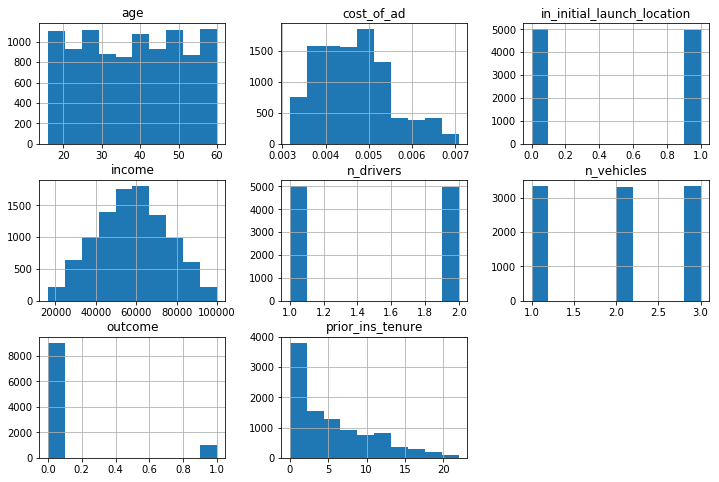

In [72]:
train_df.hist(figsize=(12,8))
plt.show()

# Data preprocessing

In [73]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [74]:
cat_features = ['device_type', 'gender', 'in_initial_launch_location']

def data_preprocessing(data, use_scale=False, scale=None, onehot=True):
    data['gender'].fillna(data['gender'].mode().iloc[0], inplace=True)
    
    if onehot: 
        one_hot = OneHotEncoder(sparse=False)
        one_hot.fit(data['in_initial_launch_location'].values.reshape(-1,1))
        location_onehot = one_hot.fit_transform(data['in_initial_launch_location'].values.reshape(-1,1))
        data = data.join(pd.DataFrame(location_onehot, columns=['location_onehot1','location_onehot2'])).drop('in_initial_launch_location',axis=1)

        one_hot = OneHotEncoder(sparse=False)
        device_onehot = one_hot.fit_transform(data['device_type'].values.reshape(-1,1))
        data = data.join(pd.DataFrame(device_onehot, columns=['device_onehot1','device_onehot2','device_onehot3','device_onehot4','device_onehot5'])).drop('device_type',axis=1)

        one_hot = OneHotEncoder(sparse=False, handle_unknown='ignore')
        gender_onehot = one_hot.fit_transform(data['gender'].values.reshape(-1,1))
        data = data.join(pd.DataFrame(gender_onehot, columns=['gender_onehot1','gender_onehot2'])).drop('gender',axis=1)
        
    else:
        ord_encoder = OrdinalEncoder()
        ords = pd.DataFrame(ord_encoder.fit_transform(train_df[cat_features]), columns = cat_features)
        data[cat_features] = ords
        
    if use_scale and scale!=None:
        data = pd.DataFrame(scale.fit_transform(data.iloc[:,0:6]), columns = data.iloc[:,0:6].columns).join(data.iloc[:,6:])

    return data

In [75]:
train = data_preprocessing(train_df, use_scale=True, scale=MinMaxScaler())
train.head()

,age,cost_of_ad,income,n_drivers,n_vehicles,prior_ins_tenure,outcome,location_onehot1,location_onehot2,device_onehot1,device_onehot2,device_onehot3,device_onehot4,device_onehot5,gender_onehot1,gender_onehot2
0,0.909091,0.656134,0.555169,1.0,0.0,0.181818,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.772727,0.399411,0.574413,1.0,1.0,0.090909,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.863636,0.245129,0.802700,0.0,1.0,0.318182,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.000000,0.497737,0.165669,1.0,1.0,0.000000,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.477273,0.118628,0.720588,1.0,0.0,0.227273,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [76]:
train = data_preprocessing(train_df, use_scale=True, scale=MinMaxScaler(), onehot=False)
train.head()

,age,cost_of_ad,device_type,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome
0,0.909091,0.656134,0.50,1.0,0.0,0.555169,2,1,4,0
1,0.772727,0.399411,0.25,0.0,0.0,0.574413,2,3,2,0
2,0.863636,0.245129,0.75,1.0,0.0,0.802700,1,3,7,0
3,0.000000,0.497737,0.00,0.0,0.0,0.165669,2,3,0,0
4,0.477273,0.118628,0.25,1.0,0.0,0.720588,2,1,5,0


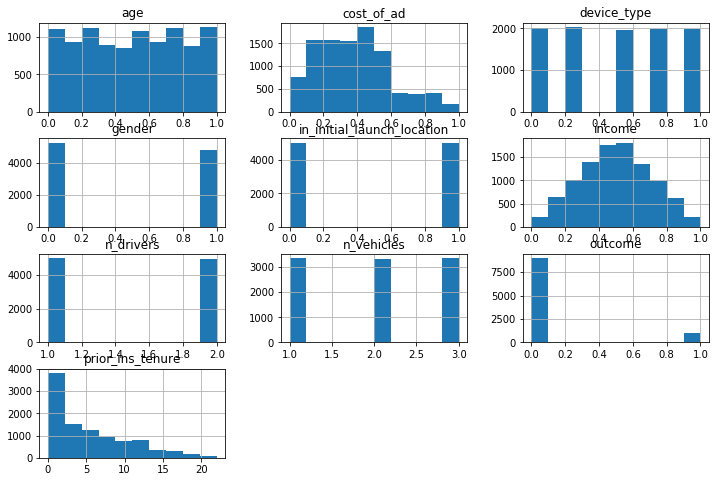

In [77]:
train.hist(figsize=(12,8))
plt.show()

# Model comparison

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

In [79]:
X = train.drop('outcome', axis=1)
y = train['outcome']

In [80]:
#X.drop(["device_onehot1","device_onehot2","device_onehot3","device_onehot4",'device_onehot5'], axis=1, inplace=True)

In [81]:
model_dict = {'lr': LogisticRegression(max_iter=200),
              'svm': SVC(), 
              'cart': DecisionTreeClassifier(), 
              'rf': RandomForestClassifier(),
              'ldr': LinearDiscriminantAnalysis()
             }

In [82]:
cv_scores = []
for i, model in enumerate(model_dict):
    cv_score = cross_val_score(model_dict[model],X, y, scoring='roc_auc', cv=5)
    cv_scores.append(cv_score)
    
cv_scores = pd.DataFrame(cv_scores, index=list(model_dict.keys()))
cv_scores.mean()

0    0.757766
1    0.764564
2    0.760695
3    0.753734
4    0.763190
dtype: float64

In [83]:
cv_score = cross_val_score(LogisticRegression(max_iter=200), X, y, scoring='roc_auc', cv=5)
print(f"scores:{cv_score}, \n mean:{cv_score.mean()}")

scores:[0.80527965 0.80533056 0.80203855 0.80058898 0.80973617], 
 mean:0.8045947822783553


In [84]:
cv_score = cross_val_score(SVC(),X, y, scoring='roc_auc', cv=5)
print(f"scores:{cv_score}, \n mean:{cv_score.mean()}")

scores:[0.74074053 0.75866555 0.77435631 0.76790797 0.74824531], 
 mean:0.7579831336698358


In [85]:
cv_score = cross_val_score(DecisionTreeClassifier(), X, y, scoring='roc_auc', cv=5)
print(f"scores:{cv_score}, \n mean:{cv_score.mean()}")

scores:[0.61509005 0.63932757 0.60488597 0.6016439  0.63186567], 
 mean:0.6185626329870717


In [86]:
cv_score = cross_val_score(RandomForestClassifier(n_estimators=500, random_state=42),X, y, scoring='roc_auc', cv=5)
print(f"scores:{cv_score}, \n mean:{cv_score.mean()}")

scores:[0.82233783 0.83680398 0.81753134 0.80910834 0.83000132], 
 mean:0.8231565629513578


In [87]:
cv_score = cross_val_score(LinearDiscriminantAnalysis(), X, y, scoring='roc_auc', cv=5)
print(f"scores:{cv_score}, \n mean:{cv_score.mean()}")

scores:[0.80434352 0.80381182 0.80124383 0.7990011  0.80953909], 
 mean:0.8035878749651879


In [88]:
cv_score = cross_val_score(XGBClassifier(n_estimators=500, random_state=42), X, y, scoring='roc_auc', cv=5)
print(f"scores:{cv_score}, \n mean:{cv_score.mean()}")

scores:[0.81899916 0.79749649 0.80931264 0.77295596 0.82751815], 
 mean:0.8052564811210026


**observation**: 
- lr is sensitive to feature scaling, rf is not so much
- minmax scaling is better
- onehot encoding gives better results

# Feature engineering

In [89]:
train = data_preprocessing(train_df, use_scale=False, scale=MinMaxScaler())
train['cost/driver'] = train['cost_of_ad']/train['n_drivers']
train['cost/vehicle'] = train['cost_of_ad']/train['n_vehicles']
train['income/driver'] = train['income']/train['n_drivers']
train['income/vehicle'] = train['income']/train['n_vehicles']
train['vehicle/driver'] = train['n_vehicles']/train['n_drivers']
train.head()

,age,cost_of_ad,income,n_drivers,n_vehicles,prior_ins_tenure,outcome,location_onehot1,location_onehot2,device_onehot1,...,device_onehot3,device_onehot4,device_onehot5,gender_onehot1,gender_onehot2,cost/driver,cost/vehicle,income/driver,income/vehicle,vehicle/driver
0,56,0.005737,62717,2,1,4,0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.002868,0.005737,31358.5,62717.000000,0.5
1,50,0.004733,64328,2,3,2,0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.002366,0.001578,32164.0,21442.666667,1.5
2,54,0.004129,83439,1,3,7,0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.004129,0.001376,83439.0,27813.000000,3.0
3,16,0.005117,30110,2,3,0,0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.002559,0.001706,15055.0,10036.666667,1.5
4,37,0.003635,76565,2,1,5,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.001817,0.003635,38282.5,76565.000000,0.5


In [90]:
num_features = [0,1,2,3,4,5,-5,-4,-3,-2,-1]
scale = MinMaxScaler()
train.iloc[:, num_features] = pd.DataFrame(scale.fit_transform(train.iloc[:,num_features]), columns = train.iloc[:,num_features].columns)
train.head()

,age,cost_of_ad,income,n_drivers,n_vehicles,prior_ins_tenure,outcome,location_onehot1,location_onehot2,device_onehot1,...,device_onehot3,device_onehot4,device_onehot5,gender_onehot1,gender_onehot2,cost/driver,cost/vehicle,income/driver,income/vehicle,vehicle/driver
0,0.909091,0.656134,0.555169,1.0,0.0,0.181818,0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.234385,0.776455,0.254021,0.608397,0.0
1,0.772727,0.399411,0.574413,1.0,1.0,0.090909,0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.142678,0.085113,0.262827,0.170182,0.4
2,0.863636,0.245129,0.802700,0.0,1.0,0.318182,0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.464724,0.051680,0.823328,0.237817,1.0
3,0.000000,0.497737,0.165669,1.0,1.0,0.000000,0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.177802,0.106420,0.075803,0.049083,0.4
4,0.477273,0.118628,0.720588,1.0,0.0,0.227273,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.042377,0.427026,0.329710,0.755424,0.0


In [91]:
X = train.drop('outcome', axis=1)
y = train['outcome']

In [96]:
cv_score = cross_val_score(LogisticRegression(),X, y, scoring='roc_auc', cv=5)
print(f"scores:{cv_score}, \n mean:{cv_score.mean()}")

scores:[0.81843353 0.82168311 0.82338285 0.80916465 0.8353393 ], 
 mean:0.8216006845126934


In [97]:
cv_score = cross_val_score(RandomForestClassifier(n_estimators=500, random_state=42),X, y, scoring='roc_auc', cv=5)
print(f"scores:{cv_score}, \n mean:{cv_score.mean()}")

scores:[0.8179089  0.82922021 0.81051462 0.80414481 0.82885124], 
 mean:0.818127955647105


In [98]:
cv_score = cross_val_score(LinearDiscriminantAnalysis(),X, y, scoring='roc_auc', cv=5)
print(f"scores:{cv_score}, \n mean:{cv_score.mean()}")

scores:[0.81010453 0.815611   0.81660652 0.80789772 0.83158639], 
 mean:0.8163612318643152


In [159]:
cv_score = cross_val_score(XGBClassifier(n_estimators=14, learning_rate=0.3), X, y, scoring='roc_auc', cv=5)
print(f"scores:{cv_score}, \n mean:{cv_score.mean()}")

scores:[0.83844009 0.84889022 0.83881624 0.81582726 0.84213142], 
 mean:0.8368210441694546


**observation**: 
- the several engieered features are effective to lr

# Train test split training

In [100]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(X, y):
    strat_train_set = train.loc[train_index]
    strat_test_set = train.loc[test_index]

In [101]:
X_train = strat_train_set.drop('outcome', axis=1)
y_train = strat_train_set['outcome']
X_test = strat_test_set.drop('outcome', axis=1)
y_test = strat_test_set['outcome']

In [102]:
from sklearn import metrics

In [103]:
def train_model(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    y_scores = model.predict_proba(x_test)

    return model, metrics.roc_auc_score(y_test, y_scores[:,1])

In [104]:
_, auc = train_model(LogisticRegression(), X_train, y_train, X_test, y_test)
print(auc)

0.820721200538864


In [105]:
_, auc = train_model(SVC(probability=True), X_train, y_train, X_test, y_test)
print(auc)

0.7660659795106363


In [106]:
_, auc = train_model(DecisionTreeClassifier(), X_train, y_train, X_test, y_test)
print(auc)

0.616808170682039


In [122]:
rf, auc = train_model(RandomForestClassifier(n_estimators=500, random_state=42), X_train, y_train, X_test, y_test)
print(auc)

0.8275710391929572


In [123]:
pd.DataFrame(rf.feature_importances_, index = train.drop('outcome', axis=1).columns).sort_values(by=[0], ascending=False)

,0
cost/vehicle,0.112034
income/vehicle,0.109639
cost/driver,0.108465
cost_of_ad,0.102708
income/driver,0.101841
income,0.100579
age,0.093012
prior_ins_tenure,0.066368
vehicle/driver,0.025508
device_onehot2,0.025315


In [124]:
_, auc = train_model(LinearDiscriminantAnalysis(), X_train, y_train, X_test, y_test)
print(auc)

0.8152473448416304


In [183]:
xg, auc = train_model(XGBClassifier(n_estimators=14, learning_rate=0.3), X_train, y_train, X_test, y_test)
print(auc)

0.8426943199974937


In [184]:
pd.DataFrame(xg.feature_importances_, index = train.drop('outcome', axis=1).columns).sort_values(by=[0], ascending=False)

,0
vehicle/driver,0.239575
n_vehicles,0.113478
device_onehot4,0.079726
device_onehot2,0.074020
gender_onehot1,0.069224
n_drivers,0.058794
location_onehot1,0.050767
device_onehot5,0.050677
device_onehot1,0.041967
device_onehot3,0.032677


In [154]:
my_model = XGBClassifier(n_estimators=15, learning_rate=0.3)

my_model.fit(X_train, y_train,
             early_stopping_rounds=5,
            eval_set=[(X_test, y_test)])

y_scores = my_model.predict_proba(X_test)
metrics.roc_auc_score(y_test, y_scores[:,1])

[0]	validation_0-error:0.09033
Will train until validation_0-error hasn't improved in 5 rounds.
[1]	validation_0-error:0.08900
[2]	validation_0-error:0.09167
[3]	validation_0-error:0.08900
[4]	validation_0-error:0.08767
[5]	validation_0-error:0.08833
[6]	validation_0-error:0.08900
[7]	validation_0-error:0.08767
[8]	validation_0-error:0.08833
[9]	validation_0-error:0.08700
[10]	validation_0-error:0.08833
[11]	validation_0-error:0.08767
[12]	validation_0-error:0.08700
[13]	validation_0-error:0.08733
[14]	validation_0-error:0.08667


0.8420514427143708

In [43]:
def zero_classifier(X):
    return np.zeros(len(X))

In [44]:
zero_classifier(X_test)

array([0., 0., 0., ..., 0., 0., 0.])

In [45]:
metrics.roc_auc_score(y_test, zero_classifier(X_test))

0.5

In [46]:
from sklearn.model_selection import cross_val_predict

In [179]:
from sklearn.metrics import roc_curve

model_dict = {'lr': LogisticRegression(),
              'svm': SVC(probability=True), 
              'cart': DecisionTreeClassifier(), 
              'rf': RandomForestClassifier(),
              'ldr': LinearDiscriminantAnalysis(),
              'xgb': XGBClassifier(n_estimators=14, learning_rate=0.3)
             }

fprs = []
tprs = []

for i, model in enumerate(model_dict):
    y_scores = cross_val_predict(model_dict[model], X_train, y_train, cv=3, method="predict_proba")[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train, y_scores)
    fprs.append(fpr)
    tprs.append(tpr)


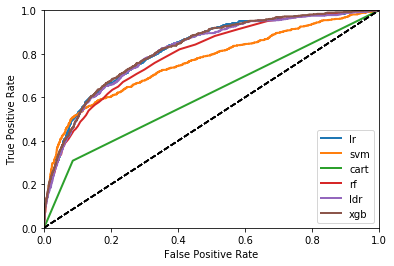

In [180]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

for i, model in enumerate(model_dict):
    plot_roc_curve(fprs[i], tprs[i], model)
    
plt.legend()
plt.show()


# Grid search

In [50]:
from sklearn.model_selection import GridSearchCV

In [51]:
RandomForestClassifier()

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [52]:
param_grid = [{'n_estimators': [50, 100, 200], 'max_features': np.arange(3,16,3)},
              
             ]
rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid, cv=5,
                           scoring='roc_auc', verbose=2, n_jobs=8)
grid_search.fit(X, y)


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.4s
[Parallel(n_jobs=8)]: Done  75 out of  75 | elapsed:   29.1s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [53]:
grid_search.best_params_

{'max_features': 3, 'n_estimators': 200}

In [54]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [55]:
cvres = grid_search.cv_results_

In [56]:
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

0.7997101624933626 {'max_features': 3, 'n_estimators': 50}
0.8162641073358706 {'max_features': 3, 'n_estimators': 100}
0.8193450536074058 {'max_features': 3, 'n_estimators': 200}
0.8035813409795965 {'max_features': 6, 'n_estimators': 50}
0.8096883058565348 {'max_features': 6, 'n_estimators': 100}
0.8164430205823393 {'max_features': 6, 'n_estimators': 200}
0.8094670471752433 {'max_features': 9, 'n_estimators': 50}
0.8090489559481243 {'max_features': 9, 'n_estimators': 100}
0.8101343830838985 {'max_features': 9, 'n_estimators': 200}
0.8003017393119659 {'max_features': 12, 'n_estimators': 50}
0.8052891359076083 {'max_features': 12, 'n_estimators': 100}
0.8101459287633268 {'max_features': 12, 'n_estimators': 200}
0.7975139570864729 {'max_features': 15, 'n_estimators': 50}
0.8051643400293356 {'max_features': 15, 'n_estimators': 100}
0.8070593988520735 {'max_features': 15, 'n_estimators': 200}


In [57]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
age                           10000 non-null int64
cost_of_ad                    10000 non-null float64
device_type                   10000 non-null object
gender                        9751 non-null object
in_initial_launch_location    10000 non-null int64
income                        10000 non-null int64
n_drivers                     10000 non-null int64
n_vehicles                    10000 non-null int64
prior_ins_tenure              10000 non-null int64
dtypes: float64(1), int64(6), object(2)
memory usage: 703.2+ KB
